In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn import metrics
import math as mt
import sklearn

In [2]:
#importing the dispersion function:
def dispersion(ClusterData, x = 'x_coord', y = 'y_coord'):
    '''
    This function calculates the dispersion of a cluster from a pandas dataframe giving the x and y coordinates of .
    The dispersion is defined as the standard deviation of the distance between all possible crater pairs.
    This method gives meaningul results for clusters with more than 3 craters in a cluster.
    It is using the radius of Mars to convert from lat/lon data to metres.

    :param ClusterData: Dataframe containing all craters in clusters
    :type ClusterData: pandas dataframe
    :param x: column name giving the longitude, defaults to 'x_coord'
    :type x: str
    :param y: column name giving the latitude, defaults to 'y_coord'
    :type y: str
    '''
    Rmars = 3390000 #radius of Mars in metres
    #x and y are the names of the column in ClusterData denoting the x and y coordinates respectively
    #Assumes that x and y are in degrees still!
    df = ClusterData.copy() #create work copy of database
    coord_array = np.array(df[[x, y]]) #create array of xy coordinates for craters in cluster
    sep_list = []
    for n in range(0, len(coord_array)): #iterating over all craters for separation calculation
        for m in range(n+1, len(coord_array)): #calculating seperation ((x2-x1)**2 + (y2 - y1)**2)**0.5 for all combinations
            dx= (coord_array[m,0] - coord_array[n,0]) *Rmars*(np.pi/180)*mt.sin(mt.radians(90 - ((coord_array[m,0]+ coord_array[n,0])/2))) #converting to metres based xy coordinates
            dy = (coord_array[m,1] - coord_array[n,1]) *Rmars*(np.pi/180)
            sep = (dx**2+ dy**2)**0.5
            sep_list.append(sep) #adding all separations to list
    dispersion = np.std(sep_list) #calculating dispersion as standard deviation
    return dispersion, sep_list

In [30]:
#importing test data
df0 = pd.read_excel('C:/Users/jae4518/OneDrive - Imperial College London/HiRise_Images_Clusters/ClustersDataSheet/ESP_057927_1620formatted.xlsx')
ID0 = 'ESP_057927_1620' #clear clustering is observed
df1 = pd.read_excel('ESP_059292_2030formatted.xlsx', index_col = [0,1])
ID1 = 'ESP_059292_2030' #clear clustering is observed
df2 = pd.read_excel('ESP_059387_1605formatted.xlsx', index_col = [0,1])
ID2 = 'ESP_059387_1605' #possible clustering
df3 = pd.read_excel('ESP_059451_1950formatted.xlsx', index_col = [0,1])
ID3 = 'ESP_059451_1950' #no clustering observed
param = pd.read_excel('C:/Users/jae4518/OneDrive - Imperial College London/HiRise_Images_Clusters/Analysis/NewClustersParameters.xlsx', index_col = 0)

In [5]:
#converting the x and y coordinates from degrees to metres:
def converter(df, ID):
    Rmars = 3390000 
    latc = param['central_latitude'].loc[param['HiRise_ID']==ID].values[0]
    lonc = param['central_longitude'].loc[param['HiRise_ID']==ID].values[0]
    df['x_coord_m'] = df['x_coord'].apply(lambda a:(a - latc)*Rmars*(np.pi/180))
    df['y_coord_m'] = df['y_coord'].apply(lambda a:(a - lonc)*Rmars*(np.pi/180)*mt.sin(mt.radians(90 - a)))

#converting the test data:
converter(df1, ID1)
converter(df2, ID2)
converter(df3, ID3)
converter(df0, ID0)
print(df1.head())

                             x_coord    y_coord  Diam_m     x_coord_m  \
HiRiseID        crater_no                                               
ESP_059292_2030 1         -91.807289  22.525381    3.83 -6.763772e+06   
                2         -91.806327  22.525668    1.52 -6.763715e+06   
                3         -91.806417  22.526157    2.48 -6.763721e+06   
                4         -91.806323  22.526244    2.93 -6.763715e+06   
                5         -91.806038  22.526240    1.00 -6.763698e+06   

                              y_coord_m  
HiRiseID        crater_no                
ESP_059292_2030 1          5.939417e+06  
                2          5.939421e+06  
                3          5.939426e+06  
                4          5.939427e+06  
                5          5.939427e+06  


In [7]:
def find_subclustering(df,ID, eps = 11, min_samples = 3):
    '''
    A function to find subclusters in crater clusters by utilizing Density based Spatial Clustering.
    The function is set up to print out a plot of the subclusters and measurements.
    It takes as input a dataframe holding the spatial coordinates for every crater in a cluster and the HiRise ID of the associated image
    The ID is soley needed for the title of the plot.
    The eps gives the largest possible distance between craters to be considered part of a class
    min_samples gives the minimum amount of craters in a class for it to be considered a cluster
    
    To read up on DBSCAN: https://en.wikipedia.org/wiki/DBSCAN and https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html
    '''
    #run DBSCAN on the clusters:
    X = df[['x_coord_m', 'y_coord_m']].to_numpy()
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    labels_true = df.index
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    # Number of clusters in labels, ignoring noise if present.
    homogen = metrics.homogeneity_score(labels_true, labels)
    comp = metrics.completeness_score(labels_true, labels)
    V = metrics.v_measure_score(labels_true, labels)
    shil = mt.nan
    davies = mt.nan
    calinski = mt.nan
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Homogeneity: %0.3f" % homogen)
    print("Completeness: %0.3f" % comp)
    print("V-measure: %0.3f" % V)
    if n_clusters_ >1:
        shil = metrics.silhouette_score(X, labels)
        davies  = sklearn.metrics.davies_bouldin_score(X, labels)
        calinski = sklearn.metrics.calinski_harabasz_score(X, labels)
        print("Silhouette Coefficient: %0.3f"
              % shil)
        print("Davies Bouldin score: %0.3f" % davies) #low equals good clustering
        print("Calinski Harabasz score: %0.3f" % calinski) #high equals good clustering
    # Plot result
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Subclustering in %s' %ID)
    plt.show()
    return n_clusters_, n_noise_, homogen, V, shil, davies, calinski

ESP_057927_1620
Estimated number of clusters: 1
Estimated number of noise points: 7
Homogeneity: 0.263
Completeness: 1.000
V-measure: 0.416


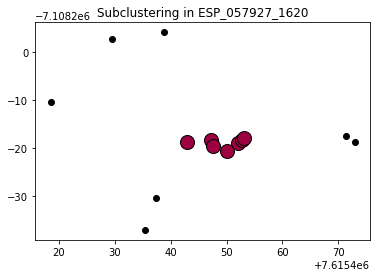

ESP_059292_2030
Estimated number of clusters: 3
Estimated number of noise points: 13
Homogeneity: 0.360
Completeness: 1.000
V-measure: 0.529
Silhouette Coefficient: 0.229
Davies Bouldin score: 1.700
Calinski Harabasz score: 11.442


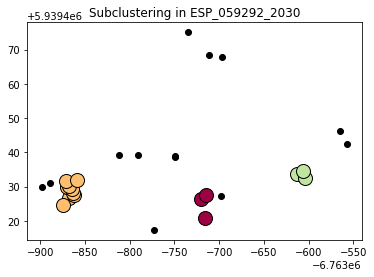

ESP_059387_1605
Estimated number of clusters: 2
Estimated number of noise points: 25
Homogeneity: 0.195
Completeness: 1.000
V-measure: 0.326
Silhouette Coefficient: 0.100
Davies Bouldin score: 0.813
Calinski Harabasz score: 4.352


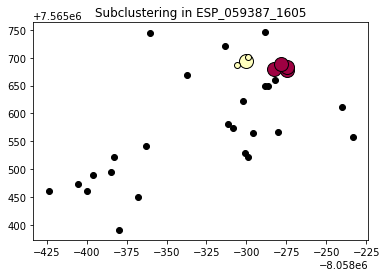

ESP_059451_1950
Estimated number of clusters: 3
Estimated number of noise points: 43
Homogeneity: 0.182
Completeness: 1.000
V-measure: 0.309
Silhouette Coefficient: -0.284
Davies Bouldin score: 3.458
Calinski Harabasz score: 0.549


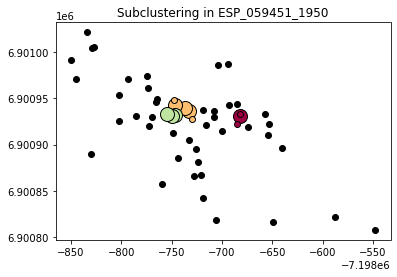

In [9]:
#Running the DBSCAN for the test clusters
print(ID0)
results0 = find_subclustering(df0, ID0 )
print(ID1)
results1 = find_subclustering(df1,ID1)
print(ID2)
results2 = find_subclustering(df2,ID2)
print(ID3)
results4 = find_subclustering(df3,ID3)

In [31]:
#importing and testing largest 3 clusters: (all have at least 150 craters in their cluster)
df4 = pd.read_excel('C:/Users/jae4518/OneDrive - Imperial College London/HiRise_Images_Clusters/ClustersDataSheet/ESP_046463_2160formatted.xlsx', index_col = [0,1])
ID4 = 'ESP_046463_2160'
df5 = pd.read_excel('C:/Users/jae4518/OneDrive - Imperial College London/HiRise_Images_Clusters/ClustersDataSheet/PSP_007009_1905formatted.xlsx', index_col = [0,1])
ID5 = 'PSP_007009_1905'
df6 = pd.read_excel('C:/Users/jae4518/OneDrive - Imperial College London/HiRise_Images_Clusters/ClustersDataSheet/ESP_051357_1880formatted.xlsx', index_col = [0,1])
ID6 = 'ESP_051357_1880'
converter(df4,ID4)
converter(df5, ID5)
converter(df6, ID6)

ESP_046463_2160
Estimated number of clusters: 37
Estimated number of noise points: 107
Homogeneity: 0.507
Completeness: 0.997
V-measure: 0.673
Silhouette Coefficient: 0.093
Davies Bouldin score: 2.129
Calinski Harabasz score: 7.827


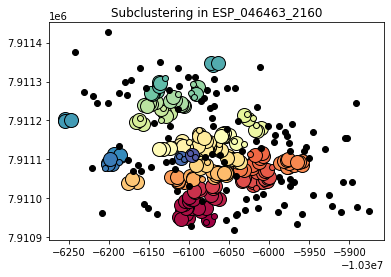

PSP_007009_1905
Estimated number of clusters: 5
Estimated number of noise points: 165
Homogeneity: 0.085
Completeness: 1.000
V-measure: 0.156
Silhouette Coefficient: -0.320
Davies Bouldin score: 1.390
Calinski Harabasz score: 2.108


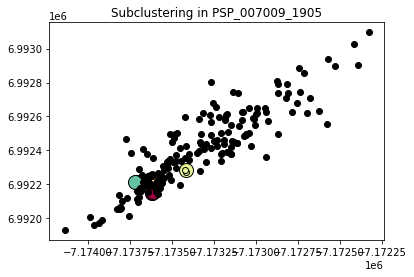

ESP_051357_1880
Estimated number of clusters: 13
Estimated number of noise points: 98
Homogeneity: 0.310
Completeness: 0.994
V-measure: 0.473
Silhouette Coefficient: -0.192
Davies Bouldin score: 1.860
Calinski Harabasz score: 4.192


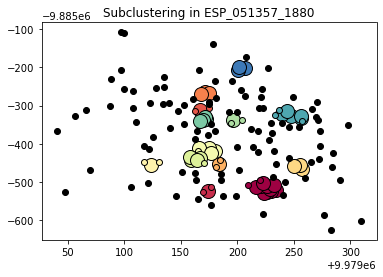

In [32]:
print(ID4)
results4 = find_subclustering(df4,ID4)
print(ID5)
results5 = find_subclustering(df5,ID5)
print(ID6)
results6 = find_subclustering(df6,ID6)

In [33]:
#find all clusters with observed subclustering:
df_obs = pd.read_excel('C:/Users/jae4518/OneDrive - Imperial College London/HiRise_Images_Clusters/Analysis/NewClustersObservations.xlsx', index_col = 0)
df_sub = df_obs.loc[df_obs['Subclustering?'] == True]
sublist = df_sub['HiRise_ID'].tolist()

ESP_050734_1805
Estimated number of clusters: 1
Estimated number of noise points: 6
Homogeneity: 0.290
Completeness: 1.000
V-measure: 0.449


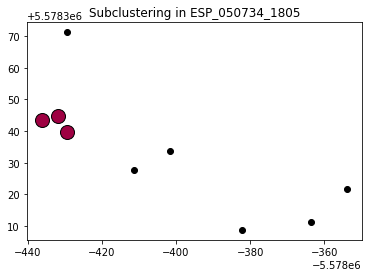

ESP_034001_2045
Estimated number of clusters: 5
Estimated number of noise points: 20
Homogeneity: 0.392
Completeness: 1.000
V-measure: 0.563
Silhouette Coefficient: 0.173
Davies Bouldin score: 2.510
Calinski Harabasz score: 3.579


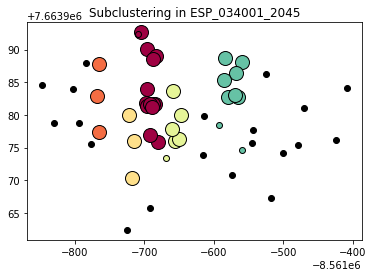

ESP_050154_1750
Estimated number of clusters: 2
Estimated number of noise points: 8
Homogeneity: 0.353
Completeness: 1.000
V-measure: 0.521
Silhouette Coefficient: 0.387
Davies Bouldin score: 1.445
Calinski Harabasz score: 27.861


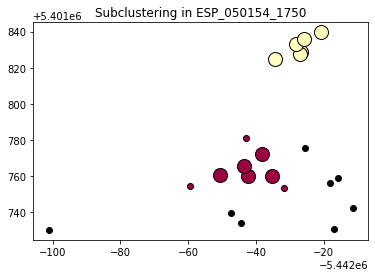

ESP_016676_1785
Estimated number of clusters: 4
Estimated number of noise points: 43
Homogeneity: 0.221
Completeness: 1.000
V-measure: 0.363
Silhouette Coefficient: -0.196
Davies Bouldin score: 1.469
Calinski Harabasz score: 2.249


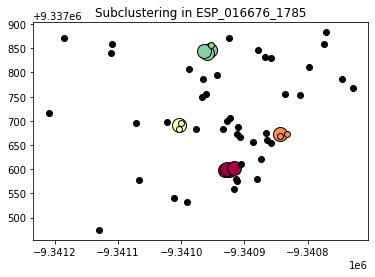

ESP_057341_1755
Estimated number of clusters: 4
Estimated number of noise points: 11
Homogeneity: 0.384
Completeness: 1.000
V-measure: 0.554
Silhouette Coefficient: 0.273
Davies Bouldin score: 1.928
Calinski Harabasz score: 4.329


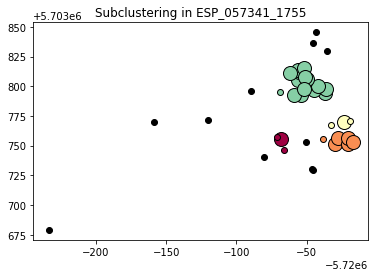

ESP_050695_1925
Estimated number of clusters: 1
Estimated number of noise points: 6
Homogeneity: 0.292
Completeness: 1.000
V-measure: 0.452


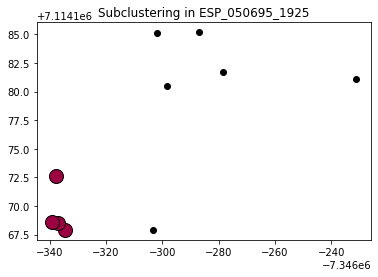

ESP_047443_1910
Estimated number of clusters: 1
Estimated number of noise points: 10
Homogeneity: 0.197
Completeness: 0.834
V-measure: 0.318


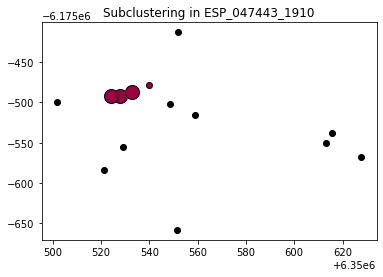

ESP_059400_1735
Estimated number of clusters: 0
Estimated number of noise points: 8
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


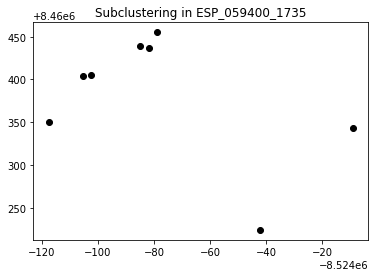

ESP_033829_2035
Estimated number of clusters: 1
Estimated number of noise points: 2
Homogeneity: 0.241
Completeness: 1.000
V-measure: 0.388


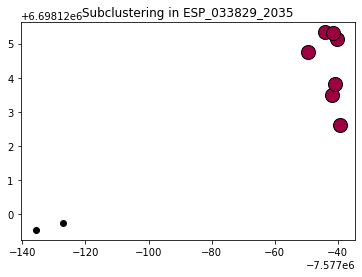

ESP_047650_1935
Estimated number of clusters: 1
Estimated number of noise points: 4
Homogeneity: 0.227
Completeness: 1.000
V-measure: 0.370


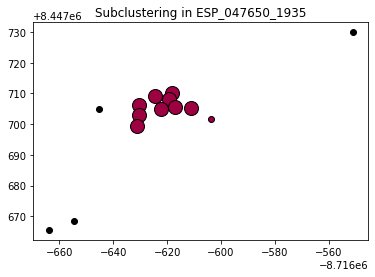

ESP_052278_1835
Estimated number of clusters: 1
Estimated number of noise points: 8
Homogeneity: 0.260
Completeness: 1.000
V-measure: 0.412


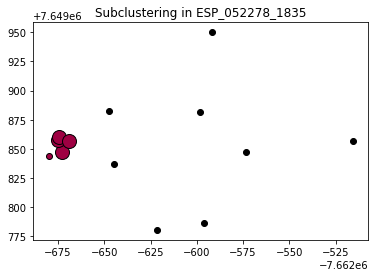

ESP_059413_1740
Estimated number of clusters: 2
Estimated number of noise points: 29
Homogeneity: 0.162
Completeness: 1.000
V-measure: 0.279
Silhouette Coefficient: -0.305
Davies Bouldin score: 1.099
Calinski Harabasz score: 3.125


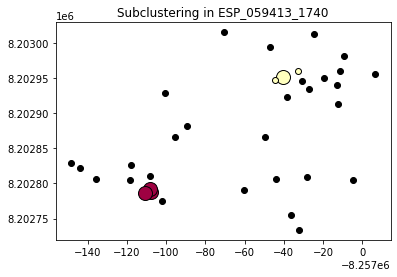

ESP_055383_2135
Estimated number of clusters: 0
Estimated number of noise points: 9
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


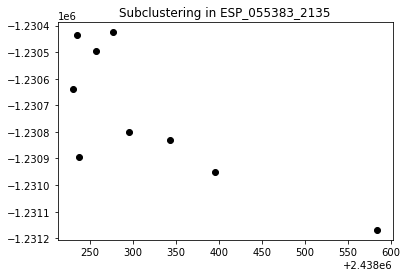

ESP_050228_2100
Estimated number of clusters: 2
Estimated number of noise points: 12
Homogeneity: 0.313
Completeness: 1.000
V-measure: 0.476
Silhouette Coefficient: 0.235
Davies Bouldin score: 1.285
Calinski Harabasz score: 12.611


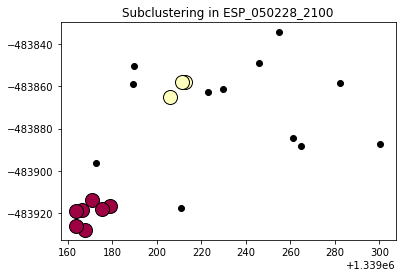

ESP_047477_2055
Estimated number of clusters: 2
Estimated number of noise points: 5
Homogeneity: 0.426
Completeness: 1.000
V-measure: 0.598
Silhouette Coefficient: 0.411
Davies Bouldin score: 2.303
Calinski Harabasz score: 6.417


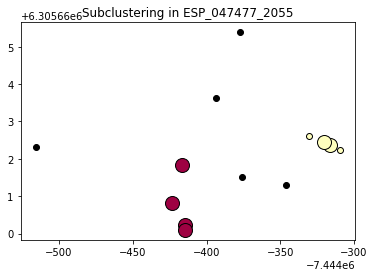

ESP_052843_2195
Estimated number of clusters: 2
Estimated number of noise points: 8
Homogeneity: 0.346
Completeness: 1.000
V-measure: 0.515
Silhouette Coefficient: 0.178
Davies Bouldin score: 1.192
Calinski Harabasz score: 5.031


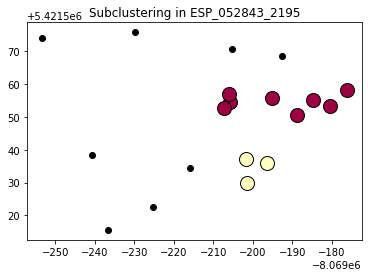

ESP_059292_2030
Estimated number of clusters: 3
Estimated number of noise points: 13
Homogeneity: 0.360
Completeness: 1.000
V-measure: 0.529
Silhouette Coefficient: 0.229
Davies Bouldin score: 1.700
Calinski Harabasz score: 11.442


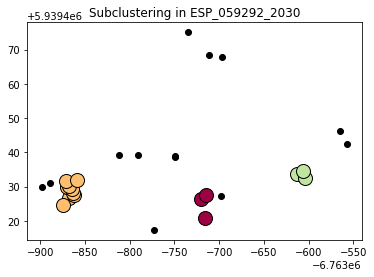

ESP_037187_1890
Estimated number of clusters: 1
Estimated number of noise points: 9
Homogeneity: 0.226
Completeness: 1.000
V-measure: 0.369


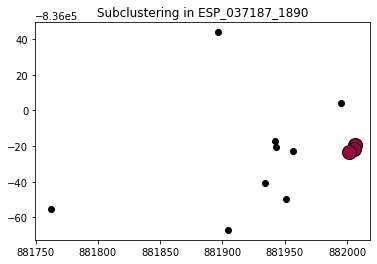

ESP_047175_1955
Estimated number of clusters: 5
Estimated number of noise points: 28
Homogeneity: 0.331
Completeness: 1.000
V-measure: 0.497
Silhouette Coefficient: -0.014
Davies Bouldin score: 3.286
Calinski Harabasz score: 2.406


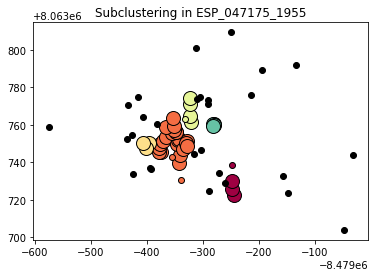

ESP_033705_1900
Estimated number of clusters: 1
Estimated number of noise points: 2
Homogeneity: 0.355
Completeness: 1.000
V-measure: 0.524


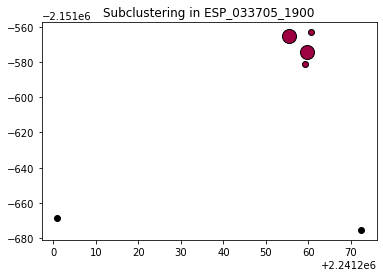

ESP_033764_2020
Estimated number of clusters: 2
Estimated number of noise points: 3
Homogeneity: 0.473
Completeness: 1.000
V-measure: 0.642
Silhouette Coefficient: 0.442
Davies Bouldin score: 2.553
Calinski Harabasz score: 24.314


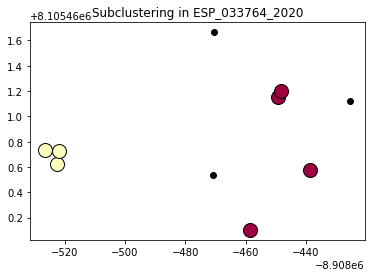

ESP_017566_2025
Estimated number of clusters: 1
Estimated number of noise points: 20
Homogeneity: 0.169
Completeness: 1.000
V-measure: 0.288


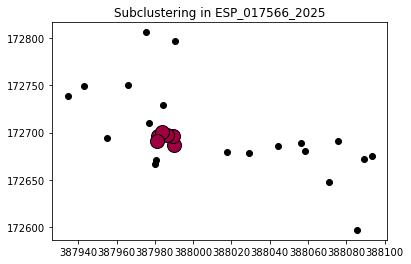

ESP_047643_2050
Estimated number of clusters: 2
Estimated number of noise points: 6
Homogeneity: 0.418
Completeness: 1.000
V-measure: 0.590
Silhouette Coefficient: 0.231
Davies Bouldin score: 1.473
Calinski Harabasz score: 3.141


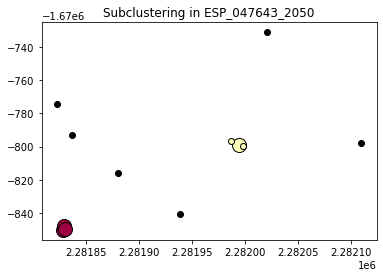

ESP_058014_1755
Estimated number of clusters: 1
Estimated number of noise points: 10
Homogeneity: 0.211
Completeness: 1.000
V-measure: 0.348


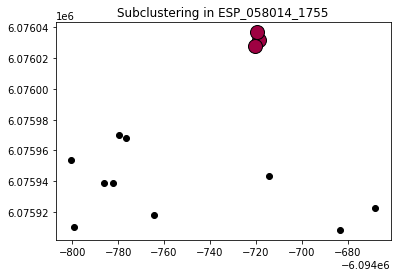

ESP_057328_1740
Estimated number of clusters: 3
Estimated number of noise points: 21
Homogeneity: 0.285
Completeness: 1.000
V-measure: 0.444
Silhouette Coefficient: -0.075
Davies Bouldin score: 2.419
Calinski Harabasz score: 1.125


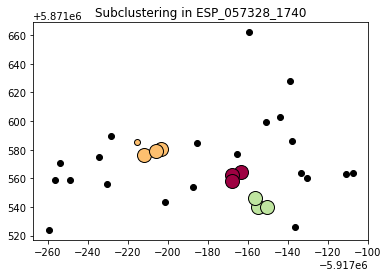

ESP_059705_1980
Estimated number of clusters: 1
Estimated number of noise points: 11
Homogeneity: 0.214
Completeness: 1.000
V-measure: 0.353


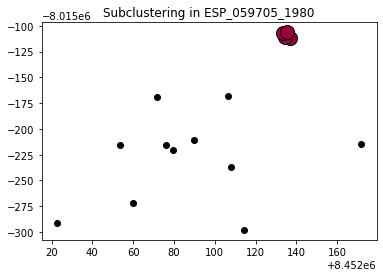

ESP_033776_1780
Estimated number of clusters: 0
Estimated number of noise points: 9
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


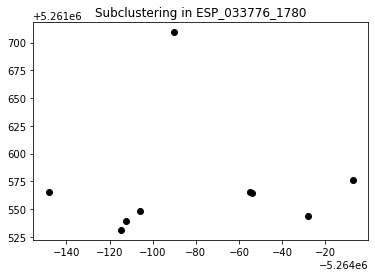

ESP_052752_2010
Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.313
Completeness: 1.000
V-measure: 0.476


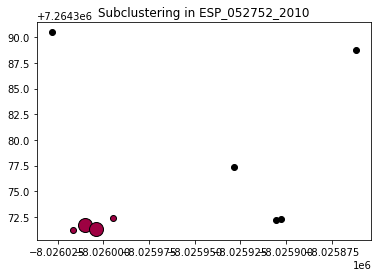

ESP_047622_2005
Estimated number of clusters: 2
Estimated number of noise points: 6
Homogeneity: 0.418
Completeness: 1.000
V-measure: 0.590
Silhouette Coefficient: 0.146
Davies Bouldin score: 1.398
Calinski Harabasz score: 2.360


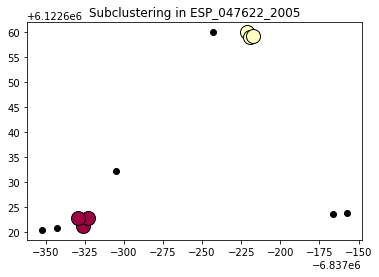

ESP_017492_1890
Estimated number of clusters: 1
Estimated number of noise points: 8
Homogeneity: 0.220
Completeness: 0.819
V-measure: 0.347


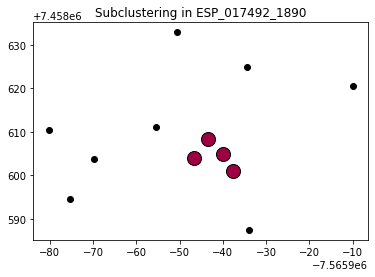

ESP_059372_2105
Estimated number of clusters: 4
Estimated number of noise points: 6
Homogeneity: 0.458
Completeness: 1.000
V-measure: 0.628
Silhouette Coefficient: 0.285
Davies Bouldin score: 3.882
Calinski Harabasz score: 6.867


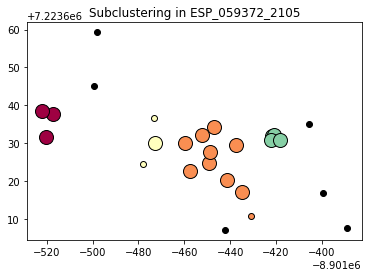

ESP_048817_1880
Estimated number of clusters: 0
Estimated number of noise points: 25
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


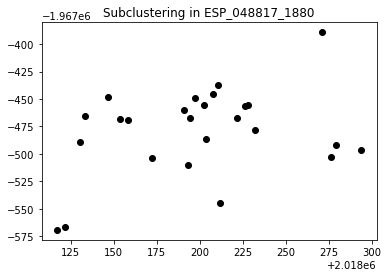

ESP_034014_1840
Estimated number of clusters: 1
Estimated number of noise points: 6
Homogeneity: 0.249
Completeness: 1.000
V-measure: 0.398


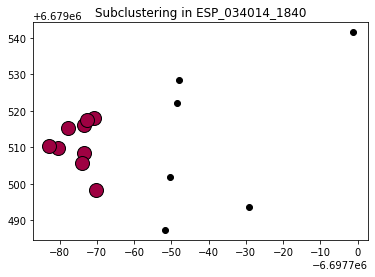

ESP_049175_1490
Estimated number of clusters: 2
Estimated number of noise points: 18
Homogeneity: 0.244
Completeness: 1.000
V-measure: 0.392
Silhouette Coefficient: -0.027
Davies Bouldin score: 1.830
Calinski Harabasz score: 1.520


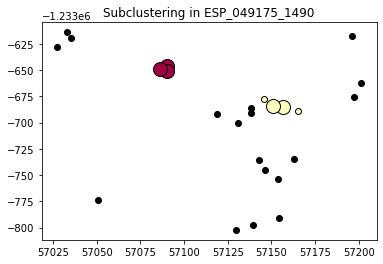

PSP_007009_1905
Estimated number of clusters: 5
Estimated number of noise points: 165
Homogeneity: 0.085
Completeness: 1.000
V-measure: 0.156
Silhouette Coefficient: -0.320
Davies Bouldin score: 1.390
Calinski Harabasz score: 2.108


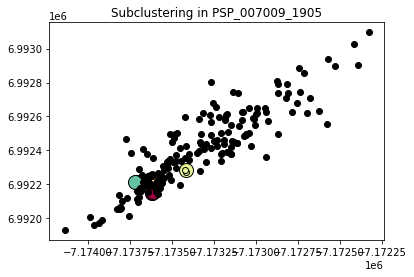

ESP_025732_1875
Estimated number of clusters: 0
Estimated number of noise points: 9
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


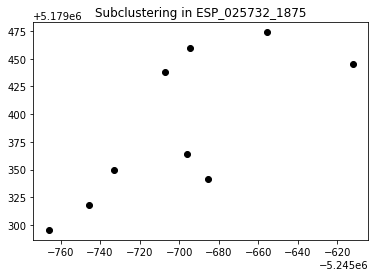

ESP_052475_1850
Estimated number of clusters: 1
Estimated number of noise points: 27
Homogeneity: 0.127
Completeness: 1.000
V-measure: 0.225


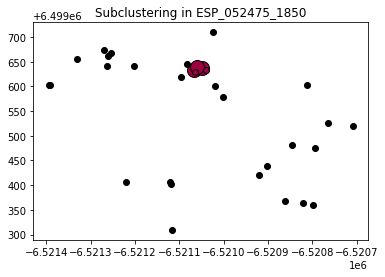

ESP_057927_1620
Estimated number of clusters: 1
Estimated number of noise points: 7
Homogeneity: 0.263
Completeness: 1.000
V-measure: 0.416


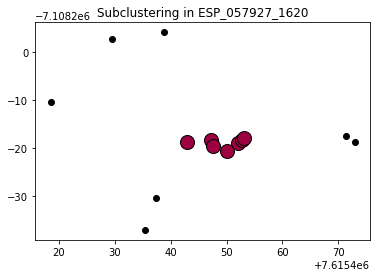

ESP_047386_1895
Estimated number of clusters: 2
Estimated number of noise points: 4
Homogeneity: 0.426
Completeness: 1.000
V-measure: 0.598
Silhouette Coefficient: 0.350
Davies Bouldin score: 2.496
Calinski Harabasz score: 1.244


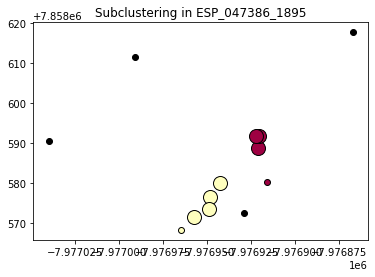

ESP_050958_2070
Estimated number of clusters: 0
Estimated number of noise points: 6
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


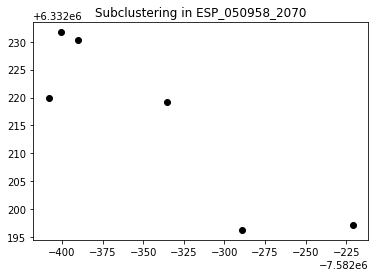

In [15]:
#running DBSCAN on the clusters with observed subclustering:
df_resultssub = pd.DataFrame(columns=['HiRise_ID', 'N_clusters', 'N_noise', 'Homogeneity', 'V_measure','Shilhouette_Coefficient', 'Davies_Bouldin_score', 'Calinski_Harabasz_score'])
for ID in sublist:
    df = pd.read_excel('C:/Users/jae4518/OneDrive - Imperial College London/HiRise_Images_Clusters/ClustersDataSheet/%sformatted.xlsx' %ID, index_col = [0,1])
    print(ID)
    converter(df, ID)
    n_clusters, n_noise, homogen, V,shil, davies, calinski = find_subclustering(df, ID)
    dic = {'HiRise_ID': ID, 'N_clusters':n_clusters, 'N_noise':n_noise, 'Homogeneity':homogen,
           'V_measure':V,'Shilhouette_Coefficient':shil, 'Davies_Bouldin_score':davies, 'Calinski_Harabasz_score': calinski}
    df_resultssub = df_resultssub.append(dic, ignore_index = True) #adding the results to new results dataframe


In [17]:
#finding all craters with no observed subclustering:
df_nosub = df_obs.loc[df_obs['Subclustering?'] == False]
nolist = df_nosub['HiRise_ID'].tolist()

ESP_059387_1605
Estimated number of clusters: 2
Estimated number of noise points: 25
Homogeneity: 0.195
Completeness: 1.000
V-measure: 0.326
Silhouette Coefficient: 0.100
Davies Bouldin score: 0.813
Calinski Harabasz score: 4.352


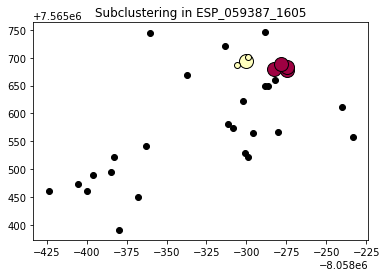

ESP_055417_1935
Estimated number of clusters: 0
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


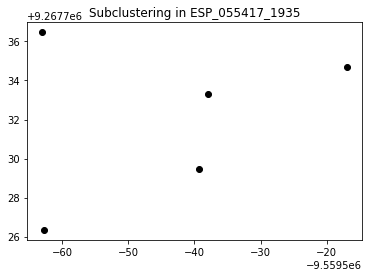

ESP_059632_1975
Estimated number of clusters: 0
Estimated number of noise points: 9
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


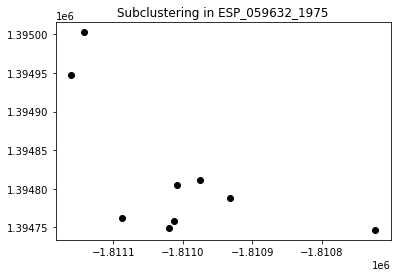

ESP_050129_2055
Estimated number of clusters: 2
Estimated number of noise points: 16
Homogeneity: 0.262
Completeness: 1.000
V-measure: 0.416
Silhouette Coefficient: -0.101
Davies Bouldin score: 2.009
Calinski Harabasz score: 1.023


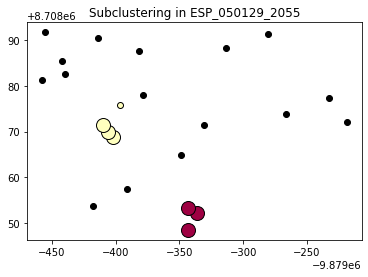

ESP_052228_1875
Estimated number of clusters: 0
Estimated number of noise points: 6
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


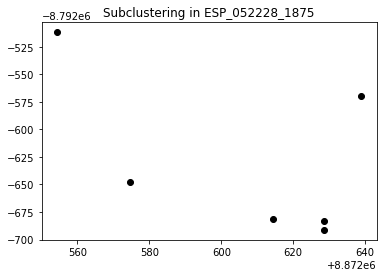

ESP_016814_2125
Estimated number of clusters: 0
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


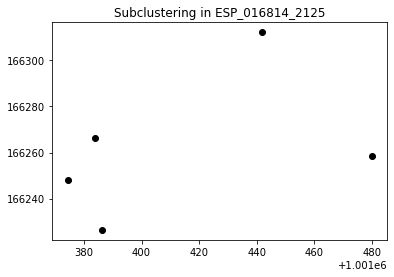

ESP_051037_2085
Estimated number of clusters: 2
Estimated number of noise points: 6
Homogeneity: 0.412
Completeness: 1.000
V-measure: 0.584
Silhouette Coefficient: 0.233
Davies Bouldin score: 17.052
Calinski Harabasz score: 0.925


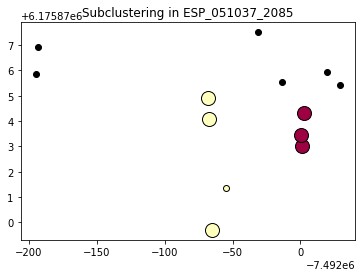

ESP_017425_2045
Estimated number of clusters: 1
Estimated number of noise points: 1
Homogeneity: 0.066
Completeness: 1.000
V-measure: 0.124


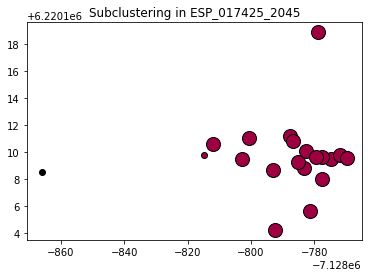

ESP_051209_2045
Estimated number of clusters: 1
Estimated number of noise points: 2
Homogeneity: 0.167
Completeness: 1.000
V-measure: 0.287


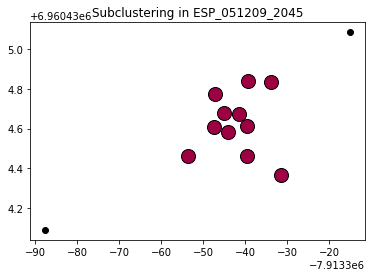

ESP_052250_1755
Estimated number of clusters: 1
Estimated number of noise points: 0
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


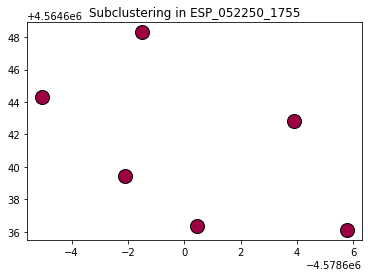

ESP_017803_2080
Estimated number of clusters: 1
Estimated number of noise points: 3
Homogeneity: 0.387
Completeness: 1.000
V-measure: 0.558


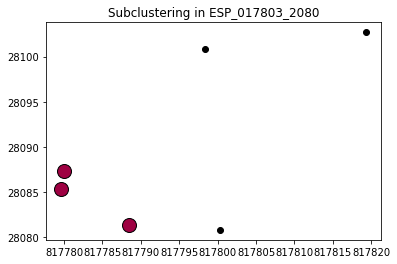

ESP_053003_1910
Estimated number of clusters: 0
Estimated number of noise points: 4
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


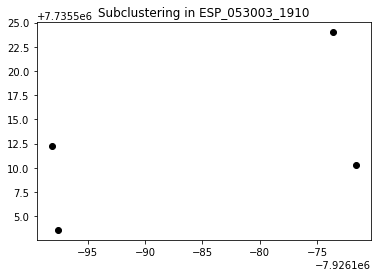

ESP_055420_1745
Estimated number of clusters: 1
Estimated number of noise points: 3
Homogeneity: 0.351
Completeness: 1.000
V-measure: 0.520


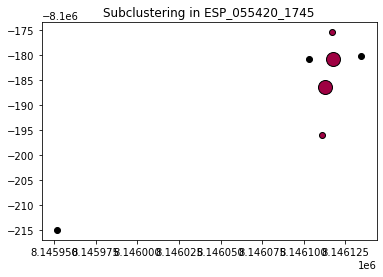

ESP_020855_2035
Estimated number of clusters: 1
Estimated number of noise points: 5
Homogeneity: 0.301
Completeness: 1.000
V-measure: 0.463


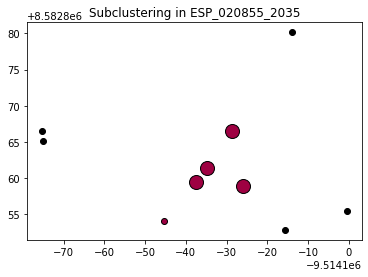

ESP_046463_2160
Estimated number of clusters: 37
Estimated number of noise points: 107
Homogeneity: 0.507
Completeness: 0.997
V-measure: 0.673
Silhouette Coefficient: 0.093
Davies Bouldin score: 2.129
Calinski Harabasz score: 7.827


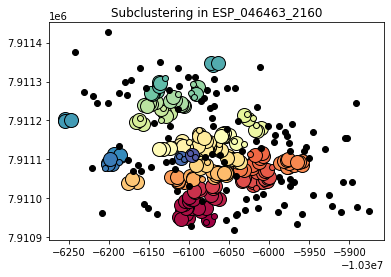

ESP_059293_2125
Estimated number of clusters: 0
Estimated number of noise points: 4
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


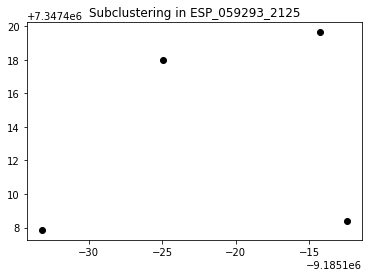

PSP_006758_2050
Estimated number of clusters: 2
Estimated number of noise points: 0
Homogeneity: 0.050
Completeness: 1.000
V-measure: 0.094
Silhouette Coefficient: 0.503
Davies Bouldin score: 0.352
Calinski Harabasz score: 17.286


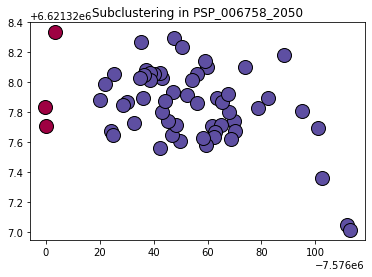

ESP_047530_2080
Estimated number of clusters: 2
Estimated number of noise points: 2
Homogeneity: 0.244
Completeness: 1.000
V-measure: 0.392
Silhouette Coefficient: 0.502
Davies Bouldin score: 0.398
Calinski Harabasz score: 26.572


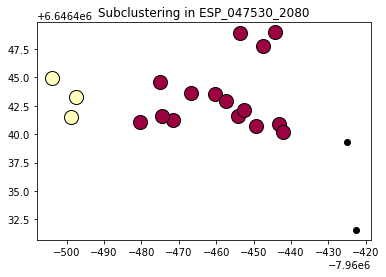

ESP_051357_1880
Estimated number of clusters: 13
Estimated number of noise points: 98
Homogeneity: 0.310
Completeness: 0.994
V-measure: 0.473
Silhouette Coefficient: -0.192
Davies Bouldin score: 1.860
Calinski Harabasz score: 4.192


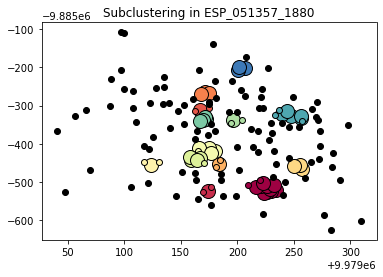

ESP_033949_1850
Estimated number of clusters: 1
Estimated number of noise points: 9
Homogeneity: 0.171
Completeness: 0.924
V-measure: 0.288


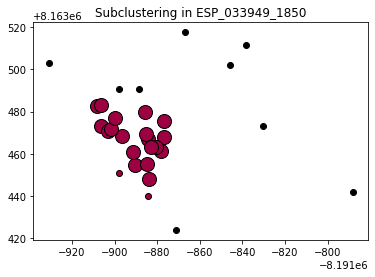

ESP_017231_1880
Estimated number of clusters: 1
Estimated number of noise points: 11
Homogeneity: 0.231
Completeness: 1.000
V-measure: 0.376


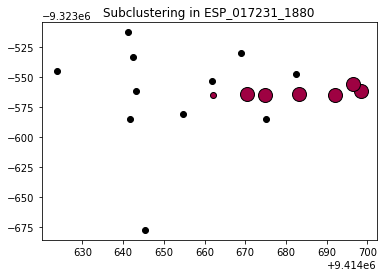

ESP_059523_2020
Estimated number of clusters: 2
Estimated number of noise points: 10
Homogeneity: 0.332
Completeness: 1.000
V-measure: 0.499
Silhouette Coefficient: -0.054
Davies Bouldin score: 1.965
Calinski Harabasz score: 0.773


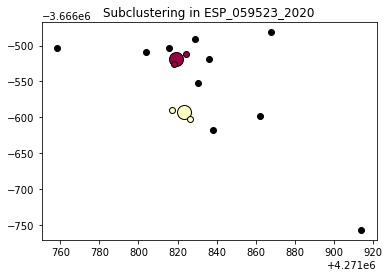

ESP_050708_2025
Estimated number of clusters: 1
Estimated number of noise points: 0
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


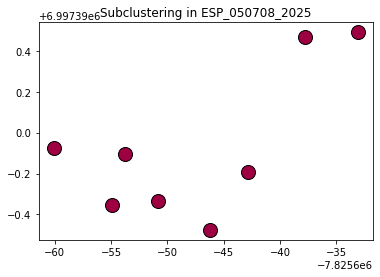

ESP_049033_1865
Estimated number of clusters: 1
Estimated number of noise points: 12
Homogeneity: 0.176
Completeness: 0.750
V-measure: 0.286


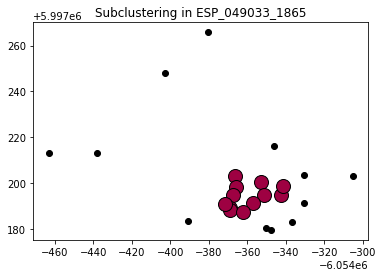

ESP_052870_2090
Estimated number of clusters: 1
Estimated number of noise points: 3
Homogeneity: 0.265
Completeness: 1.000
V-measure: 0.419


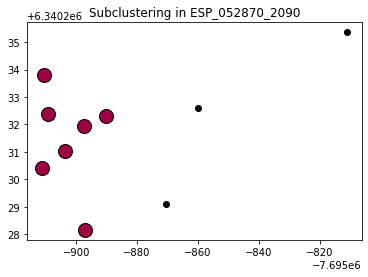

ESP_052479_1980
Estimated number of clusters: 3
Estimated number of noise points: 22
Homogeneity: 0.284
Completeness: 1.000
V-measure: 0.442
Silhouette Coefficient: -0.122
Davies Bouldin score: 2.415
Calinski Harabasz score: 0.675


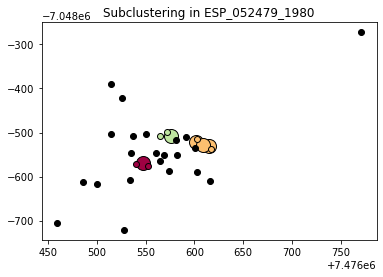

ESP_036712_1890
Estimated number of clusters: 1
Estimated number of noise points: 4
Homogeneity: 0.351
Completeness: 1.000
V-measure: 0.520


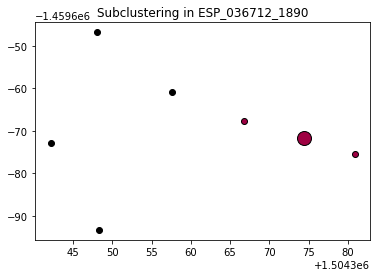

ESP_034003_1705
Estimated number of clusters: 0
Estimated number of noise points: 13
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


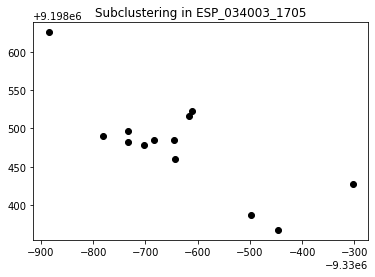

ESP_017333_1935
Estimated number of clusters: 1
Estimated number of noise points: 4
Homogeneity: 0.160
Completeness: 1.000
V-measure: 0.276


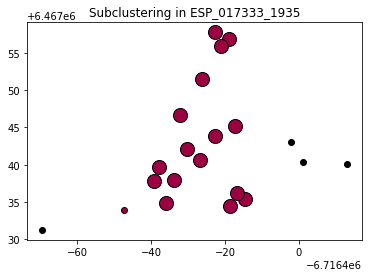

ESP_057842_1785
Estimated number of clusters: 0
Estimated number of noise points: 2
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


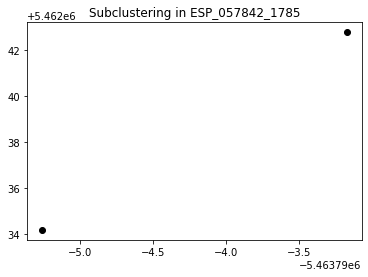

ESP_052325_1920
Estimated number of clusters: 0
Estimated number of noise points: 3
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


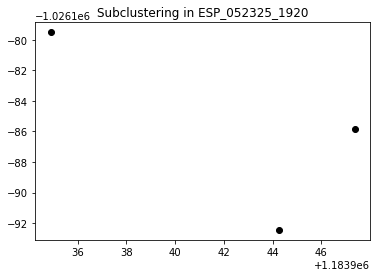

ESP_057034_2020
Estimated number of clusters: 0
Estimated number of noise points: 6
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


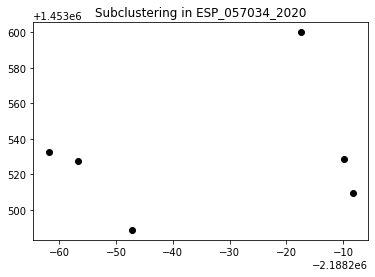

ESP_055287_2010
Estimated number of clusters: 0
Estimated number of noise points: 6
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


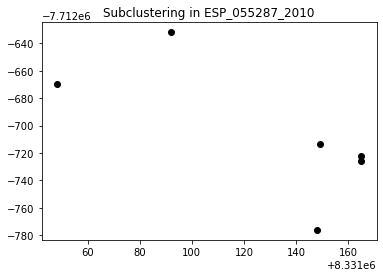

ESP_047538_1900
Estimated number of clusters: 0
Estimated number of noise points: 10
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


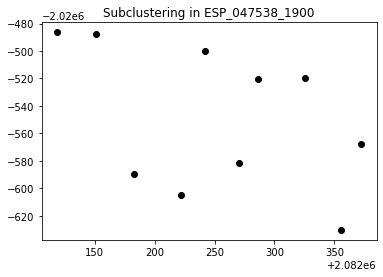

ESP_052330_1770
Estimated number of clusters: 1
Estimated number of noise points: 13
Homogeneity: 0.217
Completeness: 1.000
V-measure: 0.357


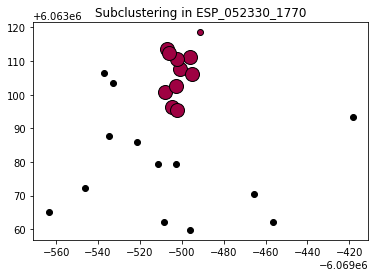

ESP_051344_1735
Estimated number of clusters: 2
Estimated number of noise points: 7
Homogeneity: 0.392
Completeness: 1.000
V-measure: 0.563
Silhouette Coefficient: 0.136
Davies Bouldin score: 3.112
Calinski Harabasz score: 1.322


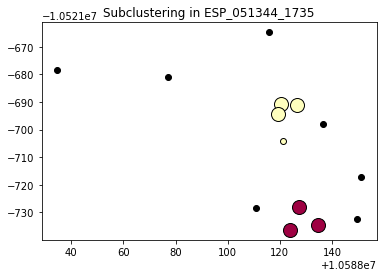

ESP_052441_2005
Estimated number of clusters: 0
Estimated number of noise points: 7
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


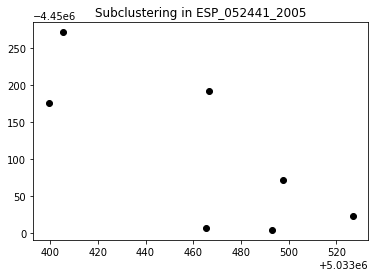

ESP_049061_1370
Estimated number of clusters: 0
Estimated number of noise points: 33
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


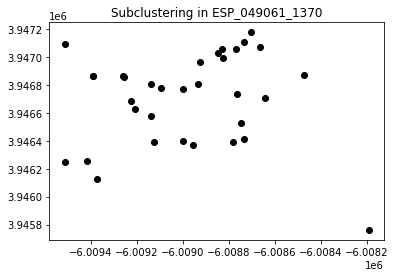

ESP_052914_1995
Estimated number of clusters: 0
Estimated number of noise points: 14
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


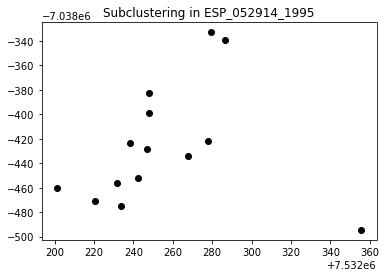

ESP_052866_1870
Estimated number of clusters: 0
Estimated number of noise points: 39
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


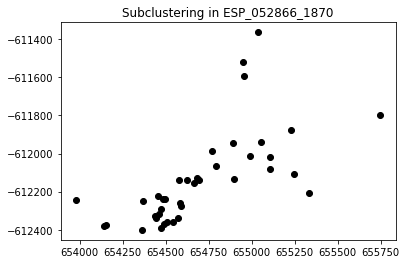

ESP_022279_1690
Estimated number of clusters: 1
Estimated number of noise points: 16
Homogeneity: 0.203
Completeness: 1.000
V-measure: 0.337


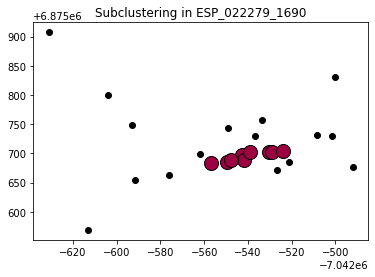

ESP_058897_2035
Estimated number of clusters: 1
Estimated number of noise points: 15
Homogeneity: 0.202
Completeness: 1.000
V-measure: 0.337


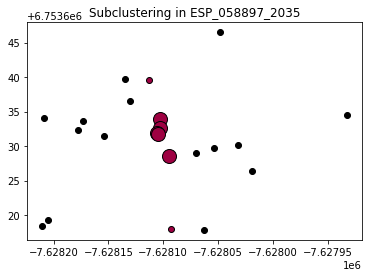

ESP_059451_1950
Estimated number of clusters: 3
Estimated number of noise points: 43
Homogeneity: 0.182
Completeness: 1.000
V-measure: 0.309
Silhouette Coefficient: -0.284
Davies Bouldin score: 3.458
Calinski Harabasz score: 0.549


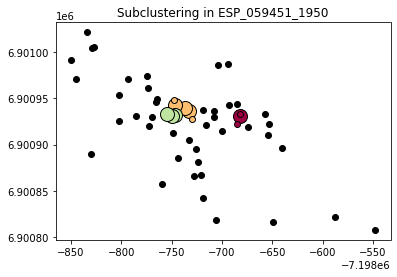

ESP_059491_1990
Estimated number of clusters: 0
Estimated number of noise points: 5
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


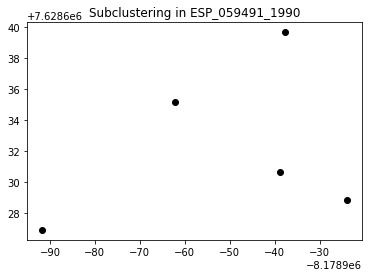

ESP_053083_2310
Estimated number of clusters: 0
Estimated number of noise points: 4
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


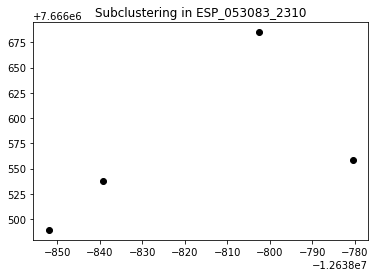

ESP_055376_2095
Estimated number of clusters: 1
Estimated number of noise points: 10
Homogeneity: 0.227
Completeness: 1.000
V-measure: 0.370


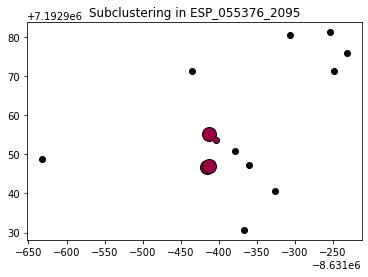

ESP_020803_2010
Estimated number of clusters: 1
Estimated number of noise points: 1
Homogeneity: 0.406
Completeness: 1.000
V-measure: 0.577


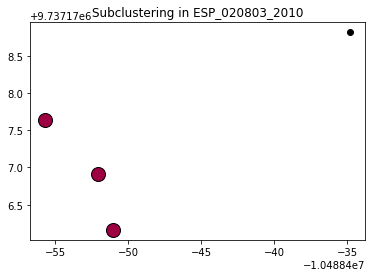

ESP_033990_1995
Estimated number of clusters: 0
Estimated number of noise points: 12
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


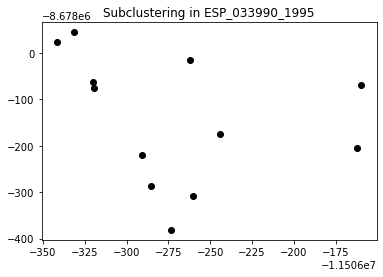

ESP_024211_2060
Estimated number of clusters: 0
Estimated number of noise points: 6
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


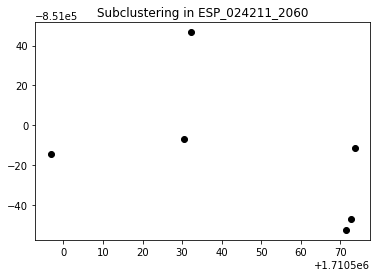

ESP_050246_2055
Estimated number of clusters: 1
Estimated number of noise points: 2
Homogeneity: 0.099
Completeness: 1.000
V-measure: 0.179


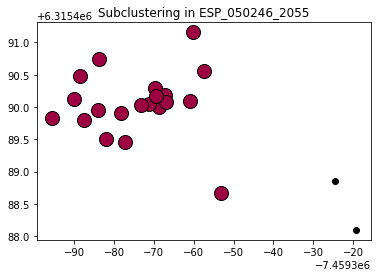

ESP_052080_1920
Estimated number of clusters: 1
Estimated number of noise points: 3
Homogeneity: 0.351
Completeness: 1.000
V-measure: 0.520


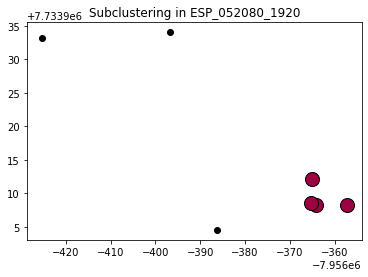

ESP_017658_1830
Estimated number of clusters: 1
Estimated number of noise points: 12
Homogeneity: 0.183
Completeness: 0.851
V-measure: 0.301


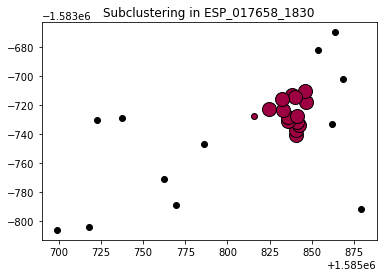

ESP_033804_2065
Estimated number of clusters: 0
Estimated number of noise points: 11
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


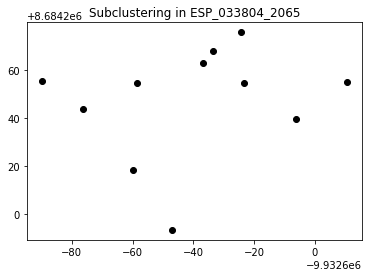

PSP_007773_1930
Estimated number of clusters: 0
Estimated number of noise points: 8
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


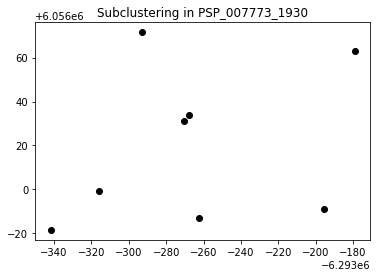

ESP_057301_2085
Estimated number of clusters: 2
Estimated number of noise points: 3
Homogeneity: 0.500
Completeness: 1.000
V-measure: 0.667
Silhouette Coefficient: 0.352
Davies Bouldin score: 1.018
Calinski Harabasz score: 4.462


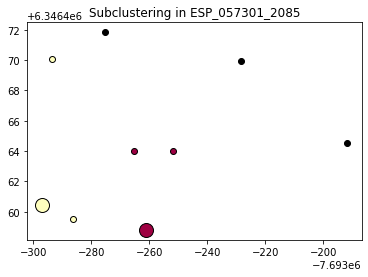

ESP_055134_1865
Estimated number of clusters: 1
Estimated number of noise points: 6
Homogeneity: 0.290
Completeness: 1.000
V-measure: 0.449


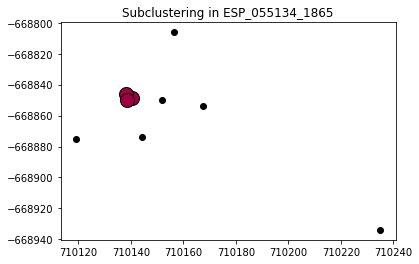

ESP_055581_1985
Estimated number of clusters: 0
Estimated number of noise points: 91
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


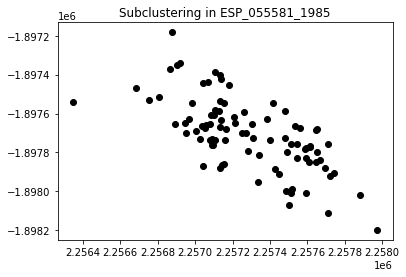

ESP_033494_1900
Estimated number of clusters: 0
Estimated number of noise points: 11
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


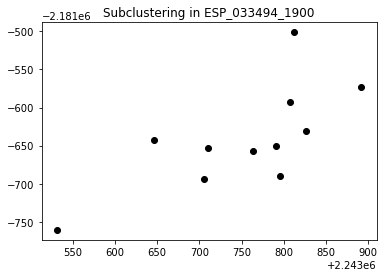

ESP_051354_2030
Estimated number of clusters: 1
Estimated number of noise points: 6
Homogeneity: 0.269
Completeness: 1.000
V-measure: 0.424


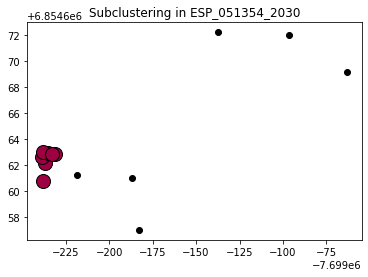

ESP_055286_2235
Estimated number of clusters: 0
Estimated number of noise points: 3
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


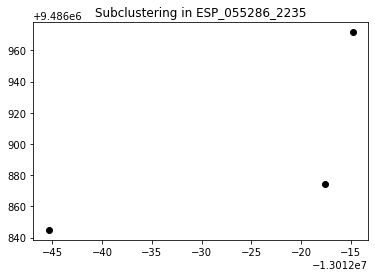

ESP_059668_1300
Estimated number of clusters: 0
Estimated number of noise points: 3
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


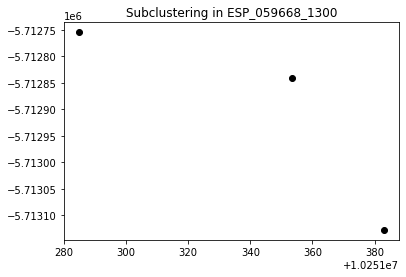

ESP_053006_1980
Estimated number of clusters: 0
Estimated number of noise points: 4
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


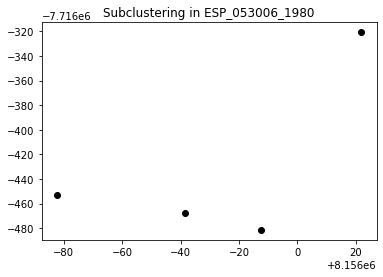

ESP_024203_1795
Estimated number of clusters: 0
Estimated number of noise points: 12
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


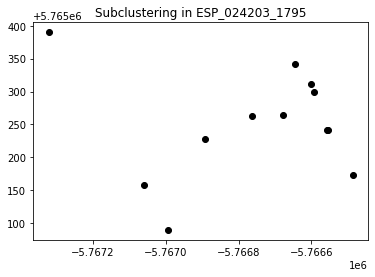

ESP_033843_1955
Estimated number of clusters: 0
Estimated number of noise points: 2
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


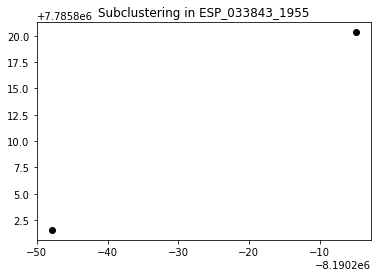

ESP_050202_2110
Estimated number of clusters: 0
Estimated number of noise points: 2
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


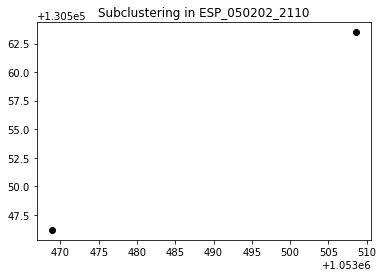

ESP_052238_2005
Estimated number of clusters: 0
Estimated number of noise points: 2
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


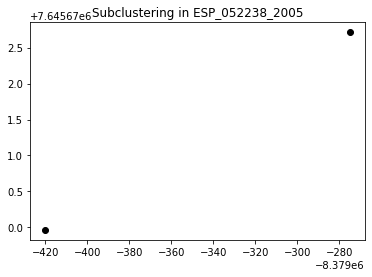

ESP_057429_1810
Estimated number of clusters: 0
Estimated number of noise points: 2
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


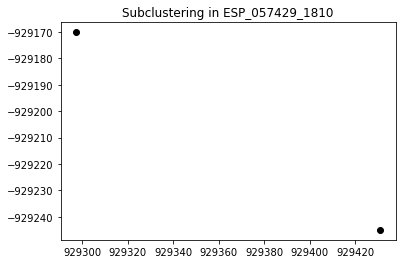

ESP_057687_1930
Estimated number of clusters: 0
Estimated number of noise points: 3
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


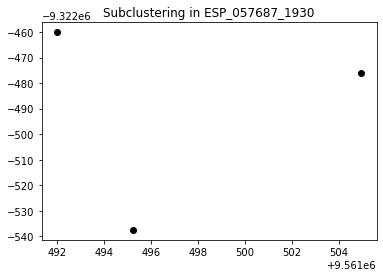

ESP_059701_1955
Estimated number of clusters: 0
Estimated number of noise points: 2
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


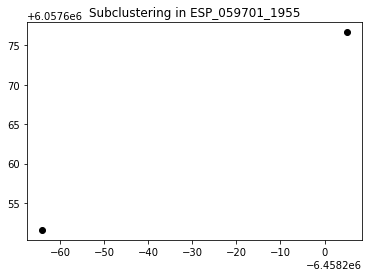

ESP_052253_1670
Estimated number of clusters: 0
Estimated number of noise points: 3
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


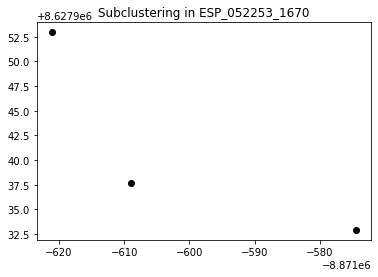

In [19]:
#running DBSCAN on clusters without observed clustering
df_resultsnosub = pd.DataFrame(columns=['HiRise_ID', 'N_clusters', 'N_noise', 'Homogeneity', 'V_measure','Shilhouette_Coefficient', 'Davies_Bouldin_score', 'Calinski_Harabasz_score'])
for ID in nolist:
    df = pd.read_excel('C:/Users/jae4518/OneDrive - Imperial College London/HiRise_Images_Clusters/ClustersDataSheet/%sformatted.xlsx' %ID, index_col = [0,1])
    print(ID)
    converter(df, ID)
    n_clusters, n_noise, homogen, V,shil, davies, calinski = find_subclustering(df,ID)
    dic = {'HiRise_ID': ID, 'N_clusters':n_clusters, 'N_noise':n_noise, 'Homogeneity':homogen,
           'V_measure':V,'Shilhouette_Coefficient':shil, 'Davies_Bouldin_score':davies, 'Calinski_Harabasz_score': calinski}
    df_resultsnosub = df_resultsnosub.append(dic, ignore_index = True) #adding results to new results dataframe

c:\users\jae4518\appdata\local\programs\python\python38-32\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\users\jae4518\appdata\local\programs\python\python38-32\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'Calinski Harabasz score')

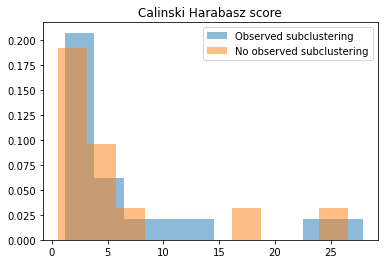

In [26]:
#Plotting Calinski Harabasz score distribution for observed and not observed 
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(df_resultssub['Calinski_Harabasz_score'], 10, density = True,alpha = 0.5, label = 'Observed subclustering')
ax.hist(df_resultsnosub['Calinski_Harabasz_score'], 10,density = True,alpha = 0.5, label = 'No observed subclustering')
ax.legend(loc = 'best')
ax.set_title('Calinski Harabasz score')

Text(0.5, 1.0, 'Davies_Bouldin_score score')

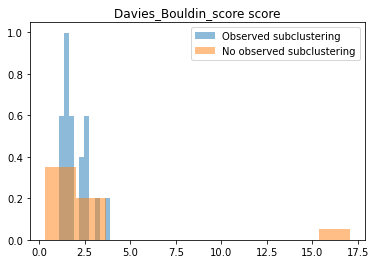

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(df_resultssub['Davies_Bouldin_score'], 10,density = True, alpha = 0.5, label = 'Observed subclustering')
ax.hist(df_resultsnosub['Davies_Bouldin_score'], 10,density = True,alpha = 0.5, label = 'No observed subclustering')
ax.legend(loc = 'best')
ax.set_title('Davies_Bouldin_score score')

Text(0.5, 1.0, 'V measure')

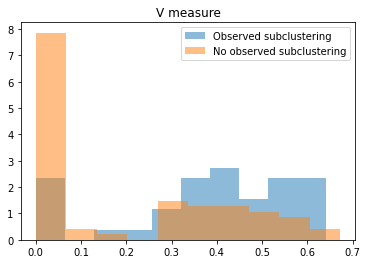

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(df_resultssub['V_measure'], 10,density = True, label = 'Observed subclustering', alpha = 0.5)
ax.hist(df_resultsnosub['V_measure'], 10,density = True, label = 'No observed subclustering', alpha = 0.5)
ax.legend(loc = 'best')
ax.set_title('V measure')